In [1]:
import os
import sys  
import torch
import pandas as pd
import numpy as np
from typing import Literal
from pathlib import Path
from collections import Counter, defaultdict
from tqdm.auto import tqdm  # for notebooks
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from math import pi
tqdm.pandas()

modules_path = "../"
if modules_path not in sys.path:
    sys.path.append(modules_path)
from inference.runner import MoERunner

/home/ilasy/miniconda3/envs/moe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


unable to import lightllm kernels


/home/ilasy/miniconda3/envs/moe/lib/python3.10/site-packages/colossalai/pipeline/schedule/_utils.py:19: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _register_pytree_node(OrderedDict, _odict_flatten, _odict_unflatten)
/home/ilasy/miniconda3/envs/moe/lib/python3.10/site-packages/torch/utils/_pytree.py:254: UserWarning: <class 'collections.OrderedDict'> is already registered as pytree node. Overwriting the previous registration.
  warnings.warn(
/home/ilasy/miniconda3/envs/moe/lib/python3.10/site-packages/colossalai/shardformer/layer/normalization.py:45: UserWarning: Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel
  warnings.warn("Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel")


In [2]:
HOME = os.environ.get("HOME")

## Load MoE inference data

In [3]:
def load_expert_routing(path):
    experts = torch.load(path)
    for k, v in experts.items():
        if isinstance(v, torch.Tensor):        
            experts[k] = [t for t in v.cpu()]
    df = pd.DataFrame(experts)
    return df
df_moe = load_expert_routing(f"{HOME}/repos/output/experts-30000.pt")
df_mixtral = load_expert_routing(f"{HOME}/repos/output/mixtral-experts-840.pt")
df_deepseek = load_expert_routing(f"{HOME}/repos/output/deepseek-experts-540.pt")

## Get top input_ids and group by Expert IDs

In [4]:
def get_expert_dicts(df: pd.DataFrame):
    experts_by_inputs = defaultdict(list)
    all_input_ids = []
    moe_layers = [c for c in df.columns if 'router' in c or 'gate' in c]
    def groupby_experts(row, layer_idx=0):
        col_name = moe_layers[layer_idx]
        filtered_experts = row[col_name][row["attention_mask"] == 1].tolist()
        for topk,input_id in zip(filtered_experts, row["input_ids"][row["attention_mask"] == 1].tolist()):
            for e in topk:
                if e != -1: #ignore overflowed tokens
                    all_input_ids.append(input_id)
                    experts_by_inputs[e].append(input_id)
    df.apply(groupby_experts,axis=1)
    all_input_ids = Counter(all_input_ids)
    for k,v in experts_by_inputs.items():
        experts_by_inputs[k] = Counter(v)
    return experts_by_inputs,all_input_ids

## Token frequency by expert ID

In [5]:
def plot_polar(experts_by_inputs,all_input_ids,tokenizer):
    expert_names = sorted(experts_by_inputs.keys()) 
    N = len(expert_names)
    angles = [n / float(N) * 2 * pi for n in range(N)]
        
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    # ax.set_theta_offset(pi / 2)
    # ax.set_theta_direction(-1)
        
    plt.xticks(angles, [f"E_{n}" for n in expert_names])    
    ax.yaxis.set_ticklabels([])
    
    for token_id,_ in all_input_ids.most_common(10):
        decoded = tokenizer.decode([token_id])
        values = [experts_by_inputs[n][token_id] for n in expert_names]            
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"{decoded}",)
        ax.fill(angles, values, alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Show the graph
    plt.show()

In [6]:
def get_top_tokens(experts_by_inputs,tokenizer,expert_ids, tokens_count = 10):
    tokens_rows = []    
    for e in expert_ids:
        tokens = tokenizer.batch_decode([[c[0]] for c in experts_by_inputs[e].most_common(tokens_count)])    
        tokens_rows.append(tokens)
    top_tokens = pd.DataFrame(tokens_rows,index=expert_ids,columns=[f"Token_{c}" for c in range(tokens_count)])
    top_tokens.index.name = "Expert ID"
    return top_tokens

### OpenMoe

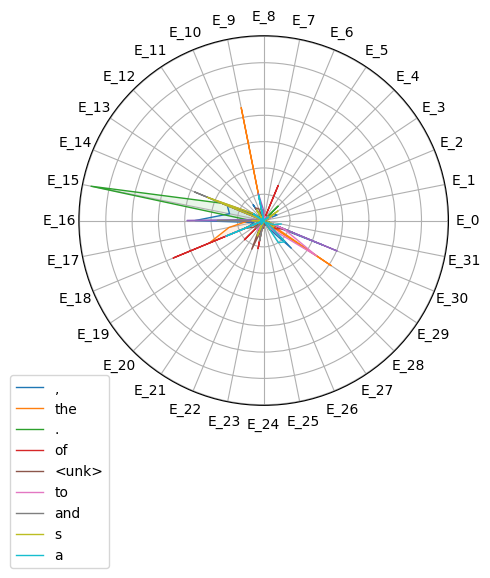

In [7]:
experts_by_inputs, all_input_ids = get_expert_dicts(df_moe)
runner = MoERunner.from_name("openmoe",seq_len=256,tokenizer_only=True)
plot_polar(experts_by_inputs,all_input_ids,runner.tokenizer)

In [8]:
top_tokens = get_top_tokens(experts_by_inputs,runner.tokenizer,expert_ids = [0,1,21,30,31])
top_tokens

,Token_0,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9
Expert ID,,,,,,,,,,
0,<unk>,sk,si,IC,sha,ound,iatric,gg,bounce,JP
1,<unk>,olb,əmə,보장,сте,ਤੇ,ੋ,ੈ,казино,Μεγάλη
21,to,been,there,people,would,some,like,just,may,<unk>
30,,",",.,:,to,of,(,s,a,-
31,be,a,your,their,his,our,when,its,if,in


### Mixtral

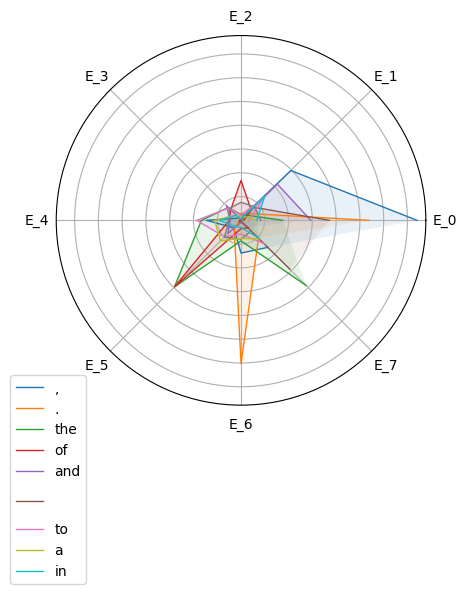

In [9]:
experts_by_inputs, all_input_ids = get_expert_dicts(df_mixtral)
runner = MoERunner.from_name("mixtral",seq_len=512,tokenizer_only=True)
plot_polar(experts_by_inputs,all_input_ids,runner.tokenizer)

In [10]:
top_tokens = get_top_tokens(experts_by_inputs,runner.tokenizer,expert_ids=[0,1,6,7])
top_tokens

,Token_0,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9
Expert ID,,,,,,,,,,
0,",",.,\n,and,the,-,,is,that,in
1,",",and,in,to,is,,\n,for,that,of
6,.,0,",",s,the,2,,a,1,to
7,the,\n,0,",",to,a,in,.,as,1


### DeepSeek

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


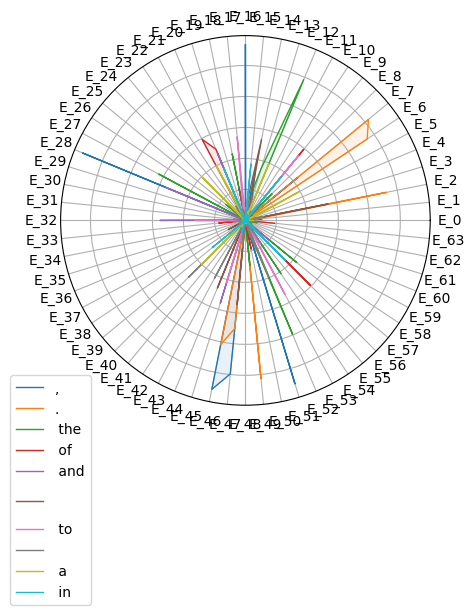

In [11]:
experts_by_inputs, all_input_ids = get_expert_dicts(df_deepseek)
runner = MoERunner.from_name("deepseek",seq_len=512,tokenizer_only=True)
plot_polar(experts_by_inputs,all_input_ids,runner.tokenizer)

In [12]:
top_tokens = get_top_tokens(experts_by_inputs,runner.tokenizer,expert_ids = [0,1,31,62,63])
top_tokens

,Token_0,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9
Expert ID,,,,,,,,,,
0,0,1,2,9,5,3,4,8,6,7
1,",",:,.,),?,”,“,on,<｜begin▁of▁sentence｜>,in
31,,the,and,.,",",in,\n,”,was,to
62,it,the,this,,there,1,them,is,2,work
63,of,1,,2,s,3,0,to,in,8
